# Using linear regression to determine increase in housing prices.

This small notebook contains some extra materials regarding linear regression in Python for the masterclass Data Science for Business of the Utrecht University of Applied Sciences. As that masterclass is introductory for Data Science, not all concepts are explored, and programming in Python or R is completely optional.

In this notebook, first implementing linear regression is showed using fictional data, and then a possible use case regarding real estate pricing is explored.

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression

First we import some packages. This helps further down the line. In order to show that linear regression works, and how well it works, we generate some random data. 100 points between X=0 and X=1 are generated. Then, points y are generated by multiplying X by 7, adding a normally distributed error term, as well as a base value of 2.

In essence, we expect Y to be equal to 7 times X plus 2. 

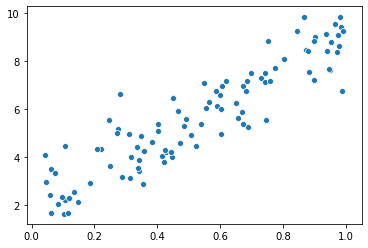

In [16]:
np.random.seed(1980)
X = np.random.uniform(size=100)
y = 7 * X + np.random.normal(size=100) + 2

sns.scatterplot(X, y)

A clear linear connection between X and Y is seen. In order to fit the linear model, we need to reshape X to fit the requirements as set by scikit-learns Linear Regression model. 

In [17]:
X = X.reshape(-1,1)

lr = LinearRegression()
lr.fit(X,y)

print(lr.coef_)
print(lr.intercept_)

lr.score(X,y)

[6.93710751]
2.0209726157248658


0.8324566976442397

The fitted model shows that it predicts Y to be equal to 6.93 times X plus 2.02. This is very close to what we originally used as a formula. Finally we score the model, and we get an r-squared value of 0.83. 

## Determining the change in housing prices of Houten, the Netherlands

Provided is a dataset with the real estate offerings of the village of Houten, the Netherlands. This data was collected in Q1-2019 and Q3-2020 and stored in an excel file in this repository. Only very basic information is stored, as the creation of an accurate model for real estate prices is quite an extensive piece of work, and goes beyond what this notebook intends to convey.

In [18]:
df_2019 = pd.read_excel('data/houten-house-prices.xlsx', sheet_name='Q1-2019')
df_2020 = pd.read_excel('data/houten-house-prices.xlsx', sheet_name='Q3-2020')

In [19]:
## Explore on 2020 data
df_2020.describe()

,living_space,lot_size,rooms,asking_price
count,111.000000,89.000000,111.000000,1.110000e+02
mean,142.369369,321.764045,5.108108,5.556209e+05
std,70.633102,403.921348,1.603130,3.606978e+05
min,36.000000,80.000000,1.000000,1.750000e+05
25%,109.000000,142.000000,4.000000,3.737500e+05
50%,128.000000,192.000000,5.000000,4.350000e+05
75%,157.000000,355.000000,6.000000,6.125000e+05
max,577.000000,2855.000000,12.000000,2.850000e+06


There are four vairbales that are provided - the square meters of the available living space, the size of the lot that particular offering has, the number of rooms, and the asking price of the object. Note that lot_size is not provided for all real estate offerings - appartments do not have a provided lot_size. We filter out all offerings without a lot size, so we compared houses to houses.

In [20]:
df_2020 = df_2020.dropna()
df_2019 = df_2019.dropna()

Let's see some exploration of the data.

## Distribution of price

As we will be making a model to predict housing prices, first I look at the distribution of the prices. If there are strong outliers, it may be wise to remove them.

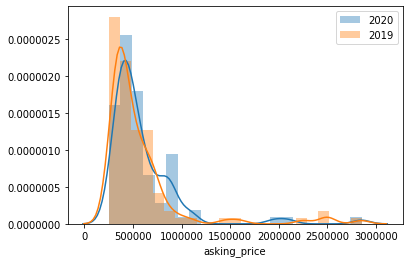

In [21]:
plt.figure()
sns.distplot(df_2020['asking_price'], label='2020')
sns.distplot(df_2019['asking_price'], label='2019')
plt.legend()
plt.show()

For both 2019 and 2020 a long tail is visible. Those outliers will heavily influence our model, considering linear regression uses mean squared error to optimize. As we're not interested in development of housing prices for the high end but for the vast majority of houses, we remove the top 10% of houses based on their prices and then check again.

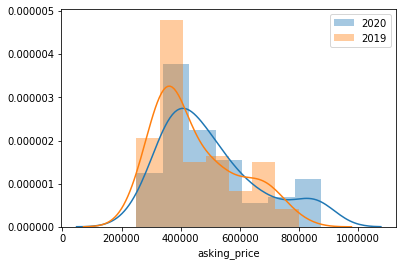

In [22]:
df_2020 = df_2020[df_2020['asking_price'] < df_2020['asking_price'].quantile(0.9)]
df_2019 = df_2019[df_2019['asking_price'] < df_2019['asking_price'].quantile(0.9)]
plt.figure()
sns.distplot(df_2020['asking_price'], label='2020')
sns.distplot(df_2019['asking_price'], label='2019')
plt.legend()
plt.show()

Both distributions now seem alright for putting in our model.

Let's further explore the data for both years..


## Living space vs lot size

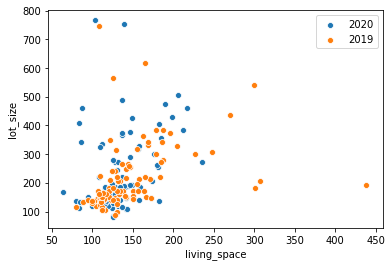

In [23]:
plt.figure()
sns.scatterplot(df_2020['living_space'], df_2020['lot_size'], label='2020')
sns.scatterplot(df_2019['living_space'], df_2019['lot_size'], label='2019')
plt.legend()
plt.show()

Clearly some strange objects are present in the 2019 data that may cause issues with our model. They all have a living space over 250 square meters, which are not present in the 2020 data (after filtering on the price quantile).

## Living space vs price

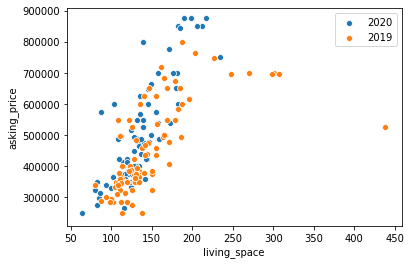

In [24]:
plt.figure()
sns.scatterplot(df_2020['living_space'], df_2020['asking_price'], label='2020')
sns.scatterplot(df_2019['living_space'], df_2019['asking_price'], label='2019')
plt.legend()
plt.show()

The effect of the large houses in 2019 is very visible. They can be considered outliers as well for our model. Besides a filter on price, we also are goin gto filter on living space of 250 square meters or lower. 

## Lot size vs price

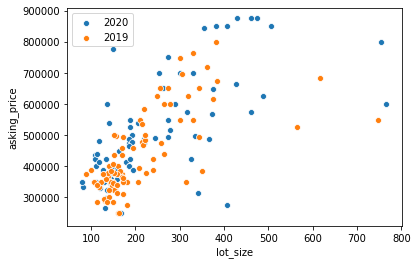

In [25]:
df_2020 = df_2020[df_2020['living_space'] < 250]
df_2019 = df_2019[df_2019['living_space'] < 250]

plt.figure()
sns.scatterplot(df_2020['lot_size'], df_2020['asking_price'], label='2020')
sns.scatterplot(df_2019['lot_size'], df_2019['asking_price'], label='2019')
plt.legend()
plt.show()

In lotsize, both 2019 and 2020 have some houses with larger lotsizes and relatively lower unexpected prices. We cap the lot_size to 500 square meters.

## Rooms vs price

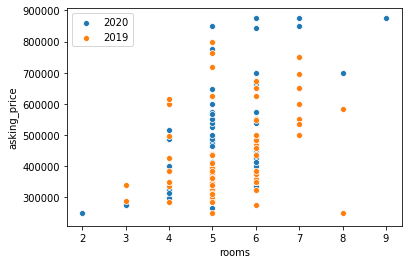

In [26]:
df_2020 = df_2020[df_2020['lot_size'] < 500]
df_2019 = df_2019[df_2019['lot_size'] < 500]

plt.figure()
sns.scatterplot(df_2020['rooms'], df_2020['asking_price'], label='2020')
sns.scatterplot(df_2019['rooms'], df_2019['asking_price'], label='2019')
plt.legend()
plt.show()

The plot for rooms shows relatively little signal. In order to simplify the model, the number of rooms is omitted from our regression.

Before we make the model, first we look at the change in mean and median prices of our dataset.



In [27]:
mean_2019 = round(df_2019['asking_price'].mean())
median_2019 = round(df_2019['asking_price'].median())
mean_2020 = round(df_2020['asking_price'].mean())
median_2020 = round(df_2020['asking_price'].median())

print("The 2020 mean of " +str(mean_2020) + " compared to the mean of 2019 of " +str(mean_2019) + " has an uplift of " +str(round(mean_2020 / mean_2019, 3)))
print("The 2020 median of " +str(median_2020) + " compared to the median of 2019 of " +str(median_2019) + " has an uplift of " +str(round(median_2020 / median_2019, 3)))

The 2020 mean of 491165 compared to the mean of 2019 of 433147 has an uplift of 1.134
The 2020 median of 450000 compared to the median of 2019 of 385000 has an uplift of 1.169


This would mean prices are 13.4% higher if you look at mean values, and 16.9% higher if you look at median values. But this is not a like-for-like comparison (even though you will find these values in media often!)

## Making two linear models.

In order to determine how much more expensive houses have gotten in Q3 of 2020 compared to Q1 of 2019, you could just look at say the average or median asking price as above. Another way is to generate two models - one for 2019 and one for 2020. Then use these same models to predict the housing prices of 2020, and see how much more they have become. That is exactlly what we're going to do here.

In [29]:
## Make linear model
from sklearn.linear_model import LinearRegression

X = df_2020[['living_space','lot_size']]
y = df_2020['asking_price']

linmodel20 = LinearRegression()
linmodel20.fit(X,y)

print(linmodel20.coef_)
print(linmodel20.intercept_)

linmodel20.score(X, y)

[3346.43602312  616.50072942]
-98180.74289991445


0.8740675083297543

The 2020 model ends up with the housing price being -98.180 euros plus 3346 * living_space plus 616 * lot_size. It explains 87% of the observed variance in housing prices.

In [30]:
## Make linear model 2019


X = df_2019[['living_space','lot_size']]
y = df_2019['asking_price']

linmodel19 = LinearRegression()
linmodel19.fit(X,y)

linmodel19.score(X, y)

print(linmodel19.coef_)
print(linmodel19.intercept_)

linmodel19.score(X, y)

[2109.50572927  755.8182453 ]
-7650.591547815711


0.7441995331658995

The 2019 model ends up with the housing price being -7.650 euros plus 2109 * living_space plus 755 * lotsize. It explains 74% of the observed variance in housing prices.

As said before, there are of course many other features that determine the price of a house that are ommitted in this model. If it were this easy, a lot of brokers would be out of a job. Nevertheless, let's see for the 2020 houses, how the 2020 model predicts the prices compared to the 2019 model. 

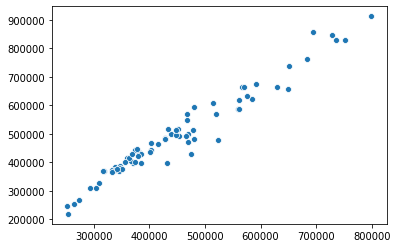

In [31]:
y_tilde_2020 = linmodel20.predict(df_2020[['living_space','lot_size']])
y_tilde_2019 = linmodel19.predict(df_2020[['living_space','lot_size']])

plt.figure()
sns.scatterplot(y_tilde_2019, y_tilde_2020)
plt.show()

Luckily, there is still a strong correlation between the two. For each house, the percentage increased is the prediction of 2020 model divided by the prediction of the 2019 model. 

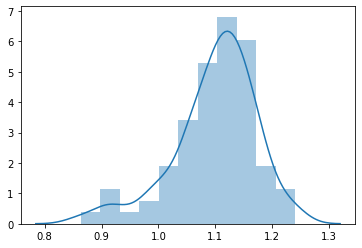

In [32]:
uplift = y_tilde_2020 / y_tilde_2019
plt.figure()
sns.distplot(uplift)
plt.show()

Overall an increase of housing prices can be seen, although some houses are predicted to be worth less in 2020 compared to 2019. 

In [33]:
print(uplift.mean())

1.0989332222803774


All in all, the model for 2020 predices houses to be 9.89% more expensive than the 2019 model. 